In [169]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [170]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '18 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)
len(df)

23668

In [171]:
df = df[~df['hashtags'].str.contains('amp')]

In [172]:
df = df[~df['hashtags'].str.contains('job|hiring|sales|retail|clerical')]

In [173]:
df = df[~df['hashtags'].str.contains('dallas|plano|irving|richardson|garland|allen|odessa|midland|sanfrancisco|losangeles|irvine|garland')]

In [174]:
len(df)

17953

In [175]:
df[~df['location'].str.contains('.ca|california')][~df['location'].str.contains('.tx|texas')]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,index,cleaned_tweet,created_at,date,date_time,hashtags,location,time,tweet_content,created_datetime,year,month,day,hour
32,32,which team will win ? mexico v usa ! #usavmex...,Sun Jun 11 11:04:23 +0000 2017,2017-06-11,2017-06-11 11:04:23,usavmex wcqualifiers wc2018 fifa worldcup wcq...,mexico,11:04:23,which team will win ? mexico v usa ! 📺https:/...,2017-06-11 11:04:23,2017,6,11,11
127,127,#sepolen - round two of sun! beautiful day to ...,Sun Jun 11 11:40:26 +0000 2017,2017-06-11,2017-06-11 11:40:26,sepolen cowboychurchfirst,"northern hills, dallas",11:40:26,#sepolen - round two of sun! beautiful day to ...,2017-06-11 11:40:26,2017,6,11,11
142,142,#shawnokeefe what a shame to teach your studen...,Sun Jun 11 11:47:48 +0000 2017,2017-06-11,2017-06-11 11:47:48,shawnokeefe verobeachhigh irresponsible pleas...,the renaissance on turtle creek,11:47:48,#shawnokeefe what a shame to teach your studen...,2017-06-11 11:47:48,2017,6,11,11
143,143,#njdominion was an awesome event!!! vs ii was ...,Sun Jun 11 11:48:16 +0000 2017,2017-06-11,2017-06-11 11:48:16,njdominion bc4life,hollywood boxing gym,11:48:16,#njdominion was an awesome event!!! @kennyomeg...,2017-06-11 11:48:16,2017,6,11,11
185,185,#sepolen - big shout out to dr.p and dr. h for...,Sun Jun 11 12:01:40 +0000 2017,2017-06-11,2017-06-11 12:01:40,sepolen running extremerunning luvcompetingwi...,"northern hills, dallas",12:01:40,#sepolen - big shout out to dr.p and dr. h fo...,2017-06-11 12:01:40,2017,6,11,12
236,236,"dear ... outside dining needs a garbage can, a...",Sun Jun 11 12:19:55 +0000 2017,2017-06-11,2017-06-11 12:19:55,dontmesswithtexas,starbucks,12:19:55,dear @starbucks ... outside dining needs a gar...,2017-06-11 12:19:55,2017,6,11,12
263,263,"at 11:45 pm, 2 sw tatum [lea co, nm] mesonet r...",Sun Jun 11 12:25:00 +0000 2017,2017-06-11,2017-06-11 12:25:00,maf,"new mexico, usa",12:25:00,"at 11:45 pm, 2 sw tatum [lea co, nm] mesonet r...",2017-06-11 12:25:00,2017,6,11,12
283,283,my former cast mate is in hollywood this weeke...,Sun Jun 11 12:29:06 +0000 2017,2017-06-11,2017-06-11 12:29:06,1g5g,marina del rey hotel,12:29:06,my former @logotv cast mate @iamianlynch is in...,2017-06-11 12:29:06,2017,6,11,12
301,301,fun sunday at with the santos family :d #quetz...,Sun Jun 11 12:32:57 +0000 2017,2017-06-11,2017-06-11 12:32:57,quetzalphoto familyphotographer familyvacay r...,méxico,12:32:57,fun sunday at @elpueblito2016 with the santos ...,2017-06-11 12:32:57,2017,6,11,12
360,360,too many people at lacma #la,Sun Jun 11 12:48:49 +0000 2017,2017-06-11,2017-06-11 12:48:49,la,los angeles county museum of art (lacma),12:48:49,too many people at lacma 😡 #la https://t.co/fw...,2017-06-11 12:48:49,2017,6,11,12


In [176]:
ca_df = df[df['location'].str.contains('.ca|california')]
tx_df = df[df['location'].str.contains('.tx|texas')]

In [177]:
def word_cloud(state):  
    state = state.lower()
    state_df = df[df['location'].str.contains('.{}'.format(state))]
    words = state_df['hashtags'][(state_df['hashtags'].isnull() == False) & (state_df['hashtags'] != 'None')]
    stopwords = set(STOPWORDS)
    #stopwords.add("dallas")
    #stopwords.add("sanfrancisco")
    #stopwords.add("losangeles")
    #stopwords.add("sacramento")
    #stopwords.add("irvine")
    #stopwords.add("garland")
    #stopwords.add("allen")
    #stopwords.add("irving")
    #stopwords.add("plano")
    #stopwords.add("richardson")
    #stopwords.add("midland")
    #stopwords.add("odessa")
    wc = WordCloud(width=1600, height=800, background_color='white', \
                   relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return


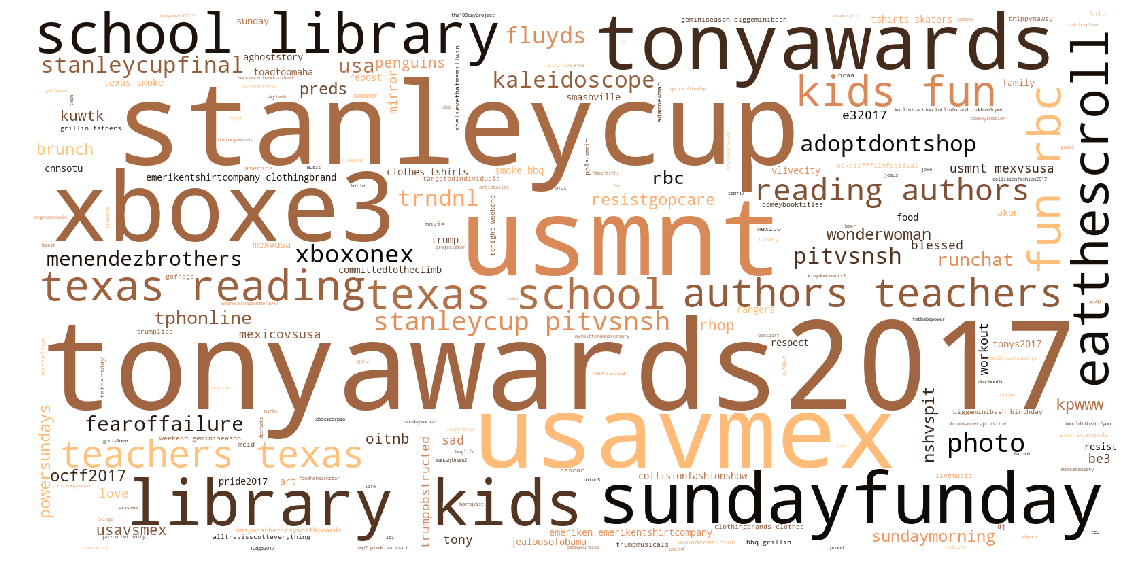

In [178]:
word_cloud('TX')

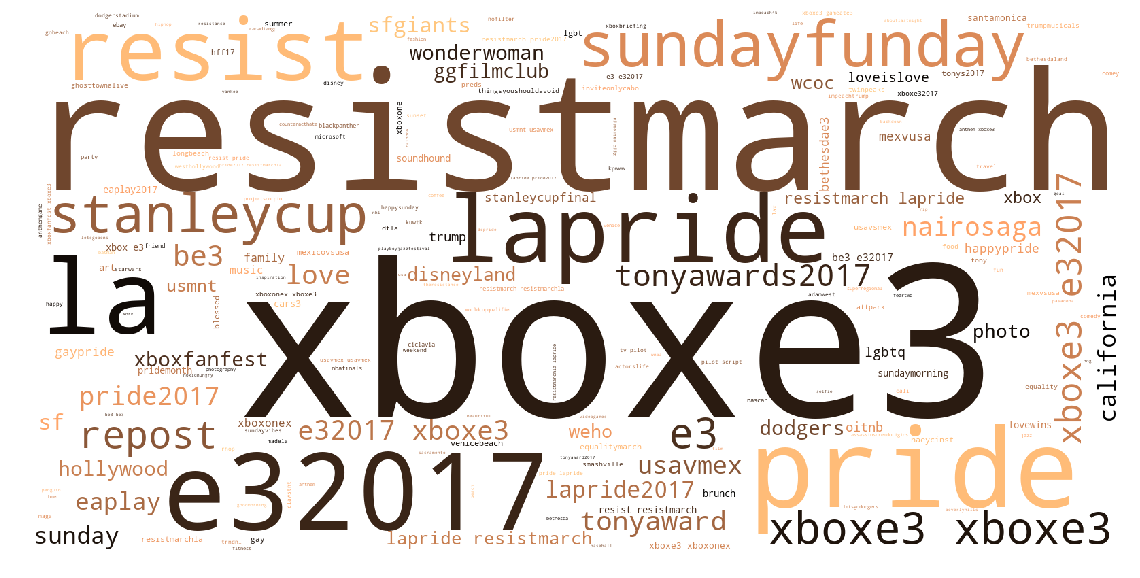

In [179]:
word_cloud('CA')

In [180]:
hastages_series = df['hashtags']
len(hastages_series)

17953

In [181]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit_transform(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [182]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = 0.1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-11 10:56:32 
 end time:   2017-06-12 04:56:15 
 total hours:  17 
 time lag:  0:15:00 
 time gap:  0:06:00 
 time windows:  180


In [183]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

In [184]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .30)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    arr_all = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        #arr_all.append(subset.mean())
        start_time += time_gap
    arr = np.array(arr)  
    #arr_all = np.array(arr_all) 
    grad = np.gradient(arr)
    #grad2 = np.gradient(grad)
    #tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spike = []
    trend = np.argwhere(grad>0).reshape(1,-1)[0]
    trend_group = group_consecutives(trend)
    trend_group2 = [i for i in trend_group if (len(i) > 6)]
    spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
    spike = np.array(spike)
    spk1 = [i[0] for i in spike[0]]
    spk2 = [i[1] for i in spike[0]]
        
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    #plt.plot(grad2, label='grad2 Slope')
    for j,k in zip(spk1,spk2):
        spike1 = (min(df['created_datetime']) + time_gap * j) 
        spike1 = spike1.replace(tzinfo=from_zone)
        spike1_et = spike1.astimezone(to_zone)
        spike1_et = spike1_et.strftime(time_format)
       
        spike2 = (min(df['created_datetime']) + time_gap * k) 
        spike2 = spike2.replace(tzinfo=from_zone)
        spike2_et = spike2.astimezone(to_zone)
        spike2_et = spike2_et.strftime(time_format)           
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spike1_et))
        plt.axvspan(j, k, alpha=0.5, color='red')
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  arr, grad, list((hashtag,len(spike),spike))

In [ ]:
hashtag_freq_df = pd.DataFrame({'hashtag': count_vectorizer.get_feature_names(), 'occurrences':np.asarray(hashtags_countvec.sum(axis=0)).ravel().tolist()})
hashtag_freq_df['frequency'] = hashtag_freq_df['occurrences']/np.sum(hashtag_freq_df['occurrences'])
hashtag_freq_df.sort_values(by = 'occurrences',ascending = False, inplace = True)

In [48]:
hashtag_freq_df.head(20)

,hashtag,occurrences,frequency
2985,eaplay,168,0.008073
6972,nowplaying,149,0.007160
5446,la,118,0.005671
5538,lapride,104,0.004998
2288,cubevenue,102,0.004902
1667,cars3,91,0.004373
2967,e32017,86,0.004133
7470,photo,82,0.003941
2728,dodgers,81,0.003893
7752,pride,80,0.003844


In [148]:
trend = np.argwhere(grad>0).reshape(1,-1)[0]
trend_group = group_consecutives(trend)
trend_group2 = [i for i in trend_group if (len(i) > 6)]
spike = []
spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
spike = np.array(spike)
spk1 = [i[0] for i in spike[0]]
spk2 = [i[1] for i in spike[0]]
print(spk1)
print(spk2)

[170, 216, 300, 310]
[176, 225, 306, 316]


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [ ]:
for i,j,k in zip(len(spike[0]),spk1,spk2):
        spike1 = (min(df['created_datetime']) + time_gap * j) 
        spike1 = spiketime.replace(tzinfo=from_zone)
        spike1_et = spike1.astimezone(to_zone)
        spike1_et = spike1_et.strftime(time_format)
       
        spike2 = (min(df['created_datetime']) + time_gap * k) 
        spike2 = spiketime.replace(tzinfo=from_zone)
        spike2_et = spike2.astimezone(to_zone)
        spike2_et = spike2_et.strftime(time_format)
        #plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


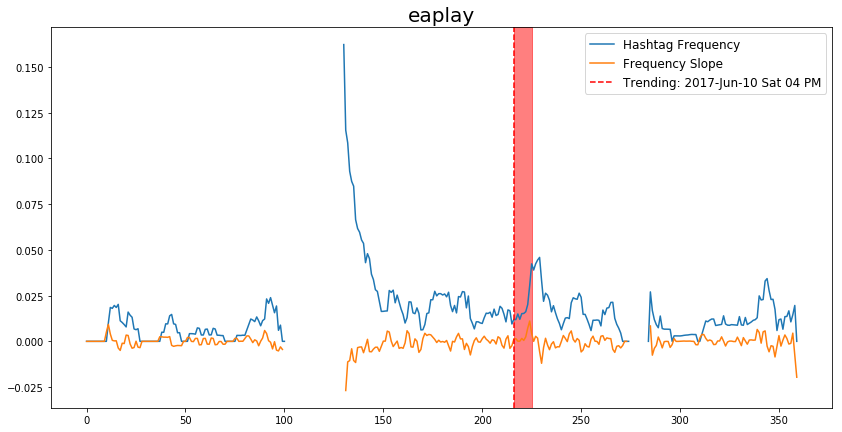

In [162]:
arr, grad, a = hashtag_trend('eaplay')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


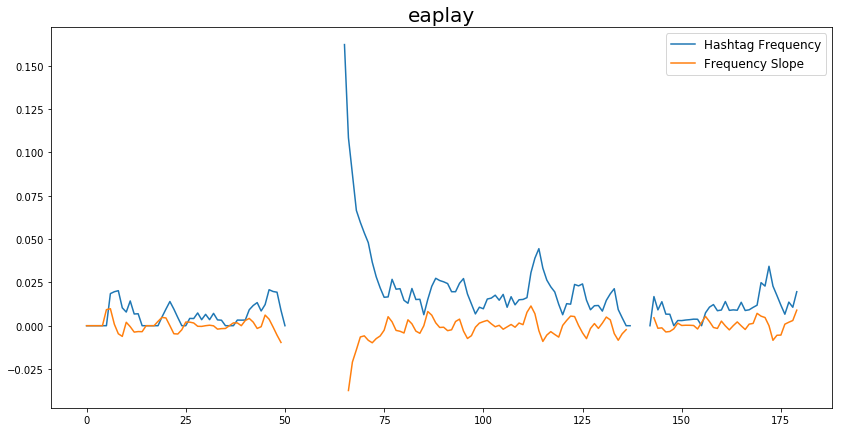

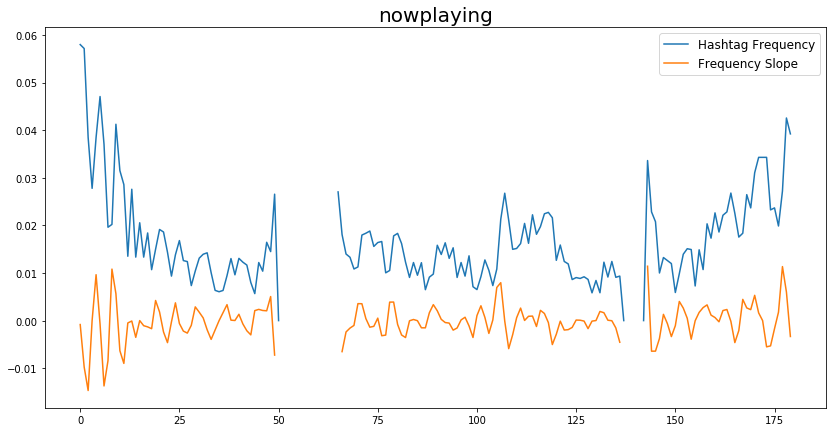

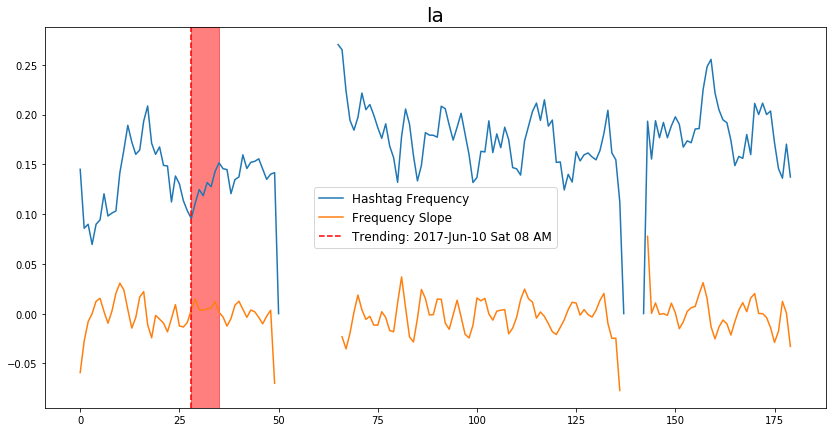

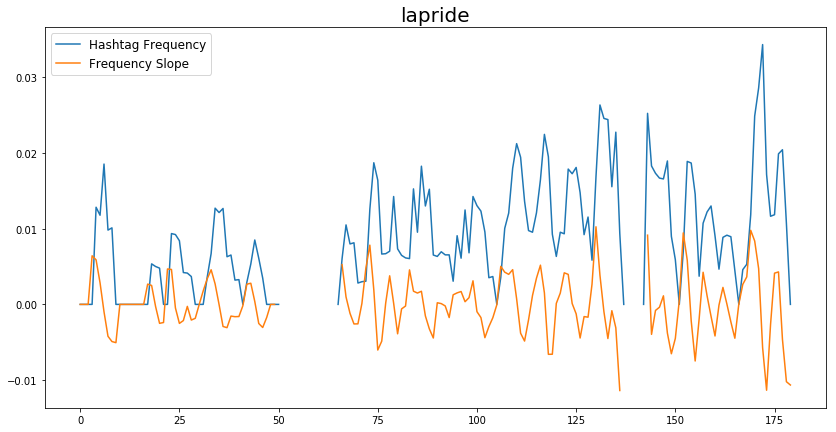

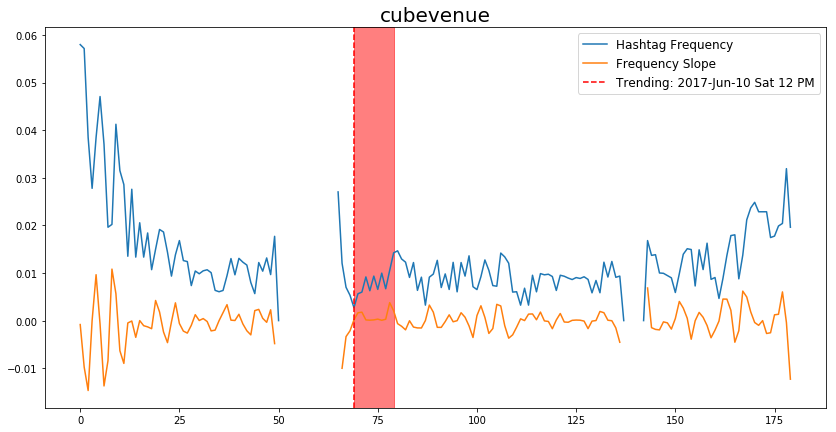

In [168]:
a = [hashtag_trend(i) for i in (hashtag_freq_df['hashtag'].head(5))]

In [ ]:
plt.plot(np.gradient(nbafinals_grad))

In [ ]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  arr, grad

In [ ]:
arr, grad = hashtag_trend('hiring')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def svd_variance(svd_model, col_index):
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(svd_model.components_)+1)]
    components = pd.DataFrame(np.round(svd_model.components_, 4), columns=col_index)
    ratios = svd_model.explained_variance_ratio_.reshape(len(svd_model.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (24,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar',legend='False');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    ax.legend_.remove()


    # Display the explained variance ratios
    for i, ev in enumerate(svd_model.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

In [ ]:
svd_variance(svd, tfd_word_index)